# ML в Биологии
## DoWhy

In [2]:
!pip install dowhy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 398.4/398.4 kB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 174.5/174.5 kB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 20.5 MB/s eta 0:00:00
  Attempting uninstall: cython
    Found existing installation: Cython 3.0.11
    Uninstalling Cython-3.0.11:
      Successfully uninstalled Cython-3.0.11


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm

import networkx as nx
from dowhy import gcm

from dowhy import CausalModel
import dowhy.datasets

import networkx as nx
from IPython.display import Image, display

import warnings
warnings.filterwarnings("ignore")

options = {
    "font_size": 14,
    "node_size": 1500,
    "node_color": "#99FF99",
    "edge_color": "#9999FF",
    "arrowsize": 25,
    "width": 3,
}

def draw_graph(graphs, options):
    nx.draw_networkx(graphs, **options)
    ax = plt.gca()
    ax.margins(0.20)
    plt.axis("off")

sns.set(style='whitegrid', palette='Set2')

---

## Задача 1.

При проведении испытания лекарства, влияющего на кровяное давление, получены следующие данные. В каждом случае указано количество успешных случаев.


| Количество успешных        | Принимали плацебо | Принимали лекарство  |
| :------------- |-------------:| -----:|
| Низкое давление      | 81 из 87 | 234 из 270 |
| Высокое давление     | 192 из 263      |   55 из 80 |


Требуется оценить эффект влияния лекарства на успех в двух следующих случаях.

* Кровяное давление пациентов измерялось до начала испытания, после чего принималось решение о приеме лекарства.

* Кровяное давление пациентов измерялось в конце испытания. При этом известно, что лекарство может оказывать эффект на кровяное давление, которое в свою очередь может оказывать эффект на выздоровление.


**1.** Нарисуйте граф причинно-следственных связей для каждого случая.

---

Обозначим
* $T$ &mdash; лечение;
* $Y$ &mdash; результат;
* $X$ &mdash; давление.


**Первый случай**

Кровяное давление пациентов измерялось до начала испытания, после чего принималось решение о приеме лекарства.


$$p(x, y, t) = p(x)p(t|x)p(y|x, t)$$


$$\widehat{\mathsf{P}}(X = 1) = \frac{263+80}{263+80+87+270}$$
$$\widehat{\mathsf{P}}(T=1\ |\ X = 0) = \frac{270}{87+270}$$
$$\widehat{\mathsf{P}}(T=1\ |\ X = 1) = \frac{80}{263+80}$$
$$\widehat{\mathsf{P}}(Y=1\ |\ T=0, X = 0) = \frac{81}{87}$$
$$\widehat{\mathsf{P}}(Y=1\ |\ T=1, X = 0) = \frac{234}{270}$$
$$\widehat{\mathsf{P}}(Y=1\ |\ T=0, X = 1) = \frac{192}{263}$$
$$\widehat{\mathsf{P}}(Y=1\ |\ T=1, X = 1) = \frac{55}{80}$$


**Второй случай**

Кровяное давление пациентов измерялось в конце испытания. При этом известно, что лекарство может оказывать эффект на кровяное давление, которое в свою очередь может оказывать эффект на выздоровление.


$$p(x, y, t) = p(t)p(x|t)p(y|x, t)$$


$$\widehat{\mathsf{P}}(T = 1) = \frac{270+80}{263+80+87+270}$$
$$\widehat{\mathsf{P}}(X=1\ |\ T = 0) = \frac{270}{270+80}$$
$$\widehat{\mathsf{P}}(X=1\ |\ T = 1) = \frac{80}{270+80}$$
$$\widehat{\mathsf{P}}(Y=1\ |\ T=0, X = 0) = \frac{81}{87}$$
$$\widehat{\mathsf{P}}(Y=1\ |\ T=1, X = 0) = \frac{234}{270}$$
$$\widehat{\mathsf{P}}(Y=1\ |\ T=0, X = 1) = \frac{192}{263}$$
$$\widehat{\mathsf{P}}(Y=1\ |\ T=1, X = 1) = \frac{55}{80}$$

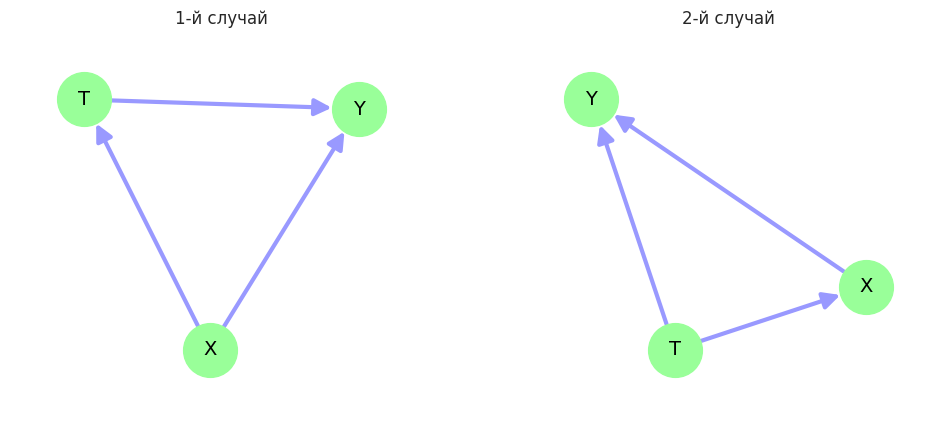

In [4]:
plt.figure(figsize=(12, 5))

causal_graphs = [
    nx.DiGraph([('X', 'T'), ('X', 'Y'), ('T', 'Y')]), # граф для случая: давление измеряется ДО решения о назначении лекарства
    nx.DiGraph([('T', 'X'), ('X', 'Y'), ('T', 'Y')])  # граф для случая: давление измеряется ПОСЛЕ решения о назначении лекарства
]

for i, graphs in enumerate(causal_graphs):
    plt.subplot(1, 2, i+1)
    draw_graph(graphs, options)
    plt.title(f'{i+1}-й случай')

plt.show()

Создадим датасет.

In [5]:
data = pd.DataFrame()
data['treatment'] = [0]*(87+263) + [1]*(270+80)
data['blood_pressure'] = [0]*87 + [1]*263 + [0]*270 + [1]*80
data['result'] = [1]*81 + [0]*(87-81) + [1]*192 + [0]*(263-192) \
                + [1]*234 + [0]*(270-234) + [1]*55 + [0]*(80-55)
data.index.name = 'patient'

data

,treatment,blood_pressure,result
patient,,,
0,0,0,1
1,0,0,1
2,0,0,1
3,0,0,1
4,0,0,1
...,...,...,...
695,1,1,0
696,1,1,0
697,1,1,0



| Количество успешных        | Принимали плацебо T=0 | Принимали лекарство T=1 |
| :------------- |-------------:| -----:|
| Низкое давление X=0      | 81 из 87 | 234 из 270 |
| Высокое давление X=1    | 192 из 263      |   55 из 80 |




Постройте графы обоих вариантов **в случае интервенции**.

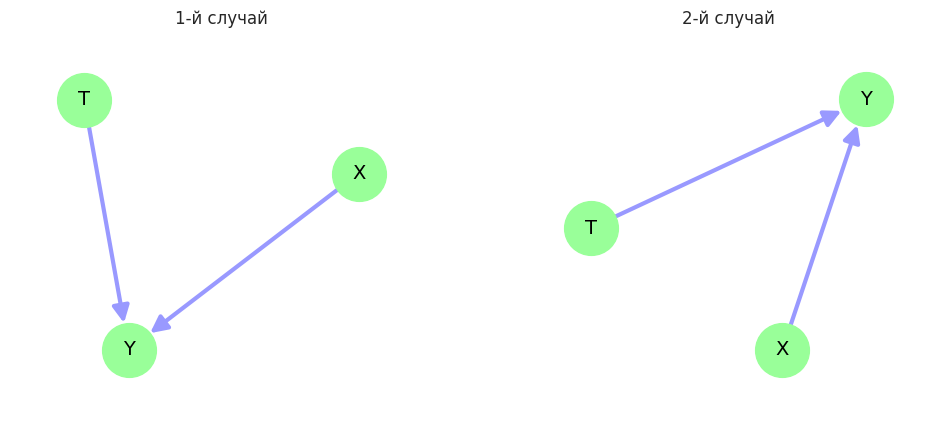

In [6]:
plt.figure(figsize=(12, 5))

causal_graphs = [
    nx.DiGraph([('X', 'Y'), ('T', 'Y')]), # do-граф для случая: давление измеряется ДО решения о назначении лекарства
    nx.DiGraph([('X', 'Y'), ('T', 'Y')]) # do-граф для случая: давление измеряется ПОСЛЕ решения о назначении лекарства
]

for i, graphs in enumerate(causal_graphs):
    plt.subplot(1, 2, i+1)
    draw_graph(graphs, options)
    plt.title(f'{i+1}-й случай')

plt.show()

**2.** Поэкспериментируем с библиотекой DoWhy.

Задайте граф причинно-следственных связей (задайте правильно названия вершин графа в соответствии с названиями колонок датасета, не меняйте тип данных) и постройте по нему модель `StructuralCausalModel` с автоматическим определением механизма причинно-следственных связей. Обучите полученную модель.

**Первый случай.**

In [7]:
causal_graph = nx.DiGraph([
    ('blood_pressure', 'treatment'),
    ('blood_pressure', 'result'),
    ('treatment', 'result')
])

In [8]:
causal_model = gcm.StructuralCausalModel(causal_graph)
gcm.auto.assign_causal_mechanisms(causal_model, data)

gcm.fit(causal_model, data)

Fitting causal mechanism of node result: 100%|██████████| 3/3 [00:00<00:00, 51.44it/s]


Выясните, какие зависимости подобрались и напечатайте параметры этих моделей.

In [12]:
model_T = causal_model.causal_mechanism('treatment')
model_Y = causal_model.causal_mechanism('result')
model_X = causal_model.causal_mechanism('blood_pressure')

model_T, model_Y, model_X

(<dowhy.gcm.causal_mechanisms.DiscreteAdditiveNoiseModel at 0x7975fdc57a00>,
 <dowhy.gcm.stochastic_models.EmpiricalDistribution at 0x7975feac2dd0>)

In [13]:
sklearn_model = model_Y.prediction_model.sklearn_model
sklearn_model.coef_, sklearn_model.intercept_

(array([-0.1903959 , -0.05383557]), 0.9230689186715357)

In [14]:
sklearn_model = model_T.prediction_model.sklearn_model
sklearn_model

HistGradientBoostingRegressor()

Как видим, были использованы модели с аддитивным шумом, в то время как наши данные категориальные.

Поменяем тип данных на строковые

In [15]:
data = data.astype(str)

Задайте модели наследования вручную. Если у вершины нет предков, то используйте эмпирическое распределение, иначе &mdash; классификатор `gcm.ClassifierFCM()`. Обучите полученную causal модель.

In [17]:
from dowhy.gcm import EmpiricalDistribution, ClassifierFCM

causal_model = gcm.StructuralCausalModel(causal_graph)

causal_model.set_causal_mechanism('blood_pressure', EmpiricalDistribution())
causal_model.set_causal_mechanism('treatment', ClassifierFCM())
causal_model.set_causal_mechanism('result', ClassifierFCM())

gcm.fit(causal_model, data)

model_T = causal_model.causal_mechanism('treatment')
model_Y = causal_model.causal_mechanism('result')
model_X = causal_model.causal_mechanism('blood_pressure')

model_T, model_Y, model_X

Fitting causal mechanism of node result: 100%|██████████| 3/3 [00:00<00:00,  7.32it/s]


(Classifier FCM based on HistGradientBoostingClassifier(),
 Classifier FCM based on HistGradientBoostingClassifier(),
 <dowhy.gcm.stochastic_models.EmpiricalDistribution at 0x797603ac98d0>)

Наконец, посчитайте оценку ATE с помощью интервенции в построенной модели.
Это фактически вычисление разницы средних таргета `result` при интервенции (искусственном установлении параметра) $treatment=1$ (т.е. всем участникам назначалось лекарство) и при $treatment=0$ (т.е. всем участникам не назначалось лекарство):

$$ATE = \mathsf{E}(Y|T:=1) - \mathsf{E}(Y|T:=0)$$

*Примечание*: в методе *average_causal_effect* `interventions_* = {'X': lambda x: '1'}` определяет условие интервенции *do(X:='1')*. Название ключей словаря соответствуют названиям переменных-вершин графа.

Зададим количество генераций новых данных на базе нашего графа:


In [18]:
num_samples_to_draw = 1_000_000

In [19]:
%%time
ATE = gcm.average_causal_effect(causal_model,
                                'result',
                                interventions_alternative={'treatment': lambda x: '1'},  # условие интервенции альтернативного эксперимента
                                interventions_reference={'treatment': lambda x: '0'},  # условие интервенции референсного эксперимента
                                num_samples_to_draw=num_samples_to_draw)

ATE

CPU times: user 35.9 s, sys: 341 ms, total: 36.2 s
Wall time: 37.3 s


-0.05366899999999997

Также интервенцию можно посчитать напрямую, но стоит учесть, что в качестве значения интервенции нужно указать строку, а полученные семплы для вычисления средних значений контрафактивных исходов необходимо будет перевести в подходящий для математических операций (численный) формат.

In [20]:
%%time
interventional_mean = []

for i in range(2):
    samples = gcm.interventional_samples(
        causal_model,
        {'treatment': lambda y: str(i) },  # условие интервенции
        num_samples_to_draw=num_samples_to_draw  # количество семплирований
    )
    interventional_mean.append(samples['result'].astype(float).mean())

ATE = interventional_mean[1] - interventional_mean[0]
ATE

CPU times: user 46.4 s, sys: 377 ms, total: 46.8 s
Wall time: 48 s


-0.05283199999999999

Сравните два подхода к вычислению ATE.

**Ответ:**

- Оба подхода дают схожие значения ATE (разница в пределах 0.001), что свидетельствует о стабильности оценки эффекта.

- Первый метод проще и быстрее, так как выполняет всю работу за нас.

- Второй метод предоставляет больше контроля над процессом, поскольку мы сами генерируете выборки и вычисляете средние значения, что может быть полезно, если требуется больше гибкости в оценке.

**Второй случай.**

Задайте модель по аналогии с первым случаем для второго варианта эксперимента и обучите её. Подход к расчёту ATE можно выбирать любой.

In [26]:
causal_graph = nx.DiGraph([
    ('treatment', 'blood_pressure'),
    ('blood_pressure', 'result'),
    ('treatment', 'result')
])

causal_model = gcm.StructuralCausalModel(causal_graph)

causal_model.set_causal_mechanism('treatment', EmpiricalDistribution())
causal_model.set_causal_mechanism('blood_pressure', ClassifierFCM())
causal_model.set_causal_mechanism('result', ClassifierFCM())

In [27]:
gcm.fit(causal_model, data)

Fitting causal mechanism of node result: 100%|██████████| 3/3 [00:00<00:00, 19.06it/s]


In [28]:
ATE = gcm.average_causal_effect(
    causal_model,
    'result',
    interventions_alternative={'treatment': lambda x: '1'},
    interventions_reference={'treatment': lambda x: '0'},
    num_samples_to_draw=num_samples_to_draw
)

ATE

0.04557800000000001

**Вывод:**

Оценка ATE показала значение **0.045578**, что указывает на положительный эффект лекарства на результат выздоровления. Использован метод **average_causal_effect** с графом причинно-следственных связей и моделями **EmpiricalDistribution** для корневых узлов и **ClassifierFCM** для зависимых.

# Propensity score и работа с ним в библиотеке DoWhy

## Задача 2. Пайплайн оценки


Для оценки эффекта библиотека DoWhy предоставляет четырехступенчатый интерфейс причинно-следственного вывода:
1. Определение модели для причинно-следственной задачи
2. Определение оценщика в рамках модели
3. Оценка причинно-следственной связи по выбранному оценщику
4. Тестирование полученной оценки


### 2.1. Определение модели

```
CausalModel(
    data,
    treatment,
    outcome,
    graph=None,
    common_causes=None,
    instruments=None,
    effect_modifiers=None,
    estimand_type='nonparametric-ate',
    proceed_when_unidentifiable=False,
    missing_nodes_as_confounders=False,
    identify_vars=False,
    **kwargs,
)
```

**Стандартный способ**

Определение причинно-следственной модели на основе данных и заданного графа. Этот граф не обязательно должен быть полным — можно предоставить частичный граф с предварительными знаниями о некоторых признаках. Тогда DoWhy автоматически рассматривает остальные признаким как потенциальные конфаундеры.

Используйте граф для случая, где `blood_pressure` является конфаундером.

In [30]:
data = data.astype({'treatment': int,
                    'blood_pressure': float,
                    'result': float})

In [31]:
causal_graph = nx.DiGraph([
    ('blood_pressure', 'treatment'),
    ('blood_pressure', 'result'),
    ('treatment', 'result')
])

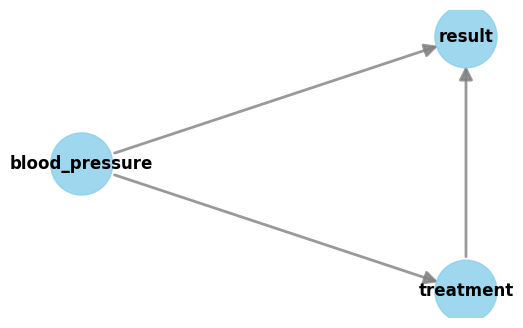

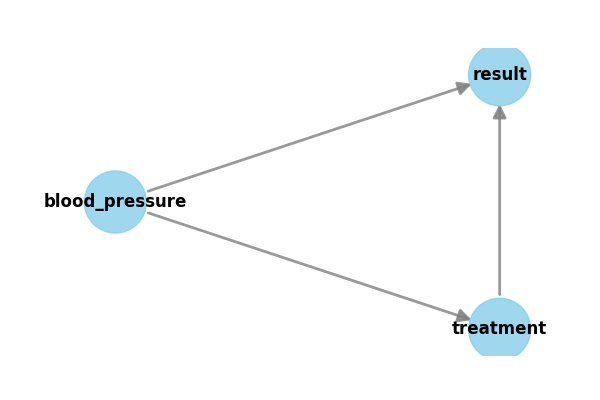

In [32]:
model = CausalModel(
    data=data,
    treatment="treatment",
    outcome="result",
    graph=causal_graph
)

model.view_model(file_name="causal_model", size=(6, 4))
display(Image(filename="causal_model.png"))

**Другой способ**

Указание ковариат и инструментов (при их наличии) в явном виде.

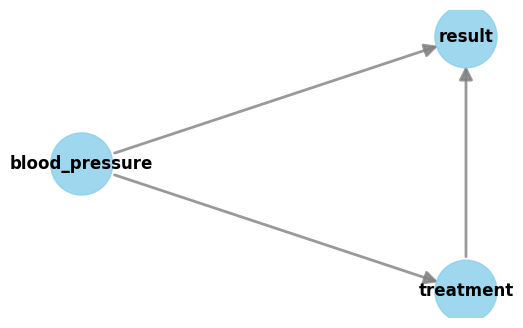

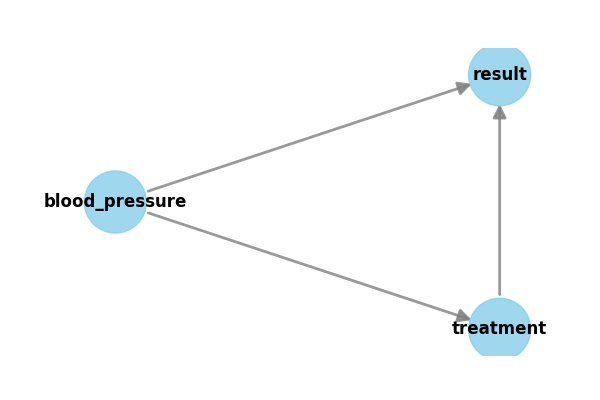

In [33]:
model_2 = CausalModel(
    data=data,
    treatment="treatment",
    outcome="result",
    common_causes="blood_pressure"
)

model_2.view_model(file_name="causal_model", size=(6, 4))
display(Image(filename="causal_model.png"))

### 2.2. Определение оценщика в рамках модели

Основываясь на причинно-следственном графе, DoWhy находит все возможные способы идентификации желаемого причинно-следственного эффекта на основе графа. Используются критерии на графах и do-исчисление, для поиска всех возможных моделей, которые могут оценить причинно-следственную связь в данном случае.

In [34]:
identified_estimand = model_2.identify_effect()
print(identified_estimand)

Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
     d                               
────────────(E[result|bloodₚᵣₑₛₛᵤᵣₑ])
d[treatment]                         
Estimand assumption 1, Unconfoundedness: If U→{treatment} and U→result then P(result|treatment,blood_pressure,U) = P(result|treatment,blood_pressure)

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



### 2.3. Оценка причинно-следственной связи

```
model.estimate_effect(
    identified_estimand,
    method_name=None,
    control_value=0,
    treatment_value=1,
    test_significance=None,
    evaluate_effect_strength=False,
    confidence_intervals=False,
    target_units='ate',
    effect_modifiers=None,
    fit_estimator=True,
    method_params=None,
)

```


Поддерживаются следущие методы
* Propensity Score Matching: "`backdoor.propensity_score_matching`"
* Propensity Score Stratification: "`backdoor.propensity_score_stratification`" &mdash; использование оценок propensity score для определения бинов, по котором выполняется стратификация
* Propensity Score-based Inverse Weighting: "`backdoor.propensity_score_weighting`"
* Linear Regression: "`backdoor.linear_regression`"
* Generalized Linear Models (e.g., logistic regression): "`backdoor.generalized_linear_model`"
* Instrumental Variables: "`iv.instrumental_variable`"
* Regression Discontinuity: "`iv.regression_discontinuity`"

Протестируйте оценку причинно-следственного эффекта при использовании propensity score как весов для исходов.

In [35]:
estimate = model.estimate_effect(
    identified_estimand,
    method_name="backdoor.propensity_score_weighting",
)

print(estimate)

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
     d                               
────────────(E[result|bloodₚᵣₑₛₛᵤᵣₑ])
d[treatment]                         
Estimand assumption 1, Unconfoundedness: If U→{treatment} and U→result then P(result|treatment,blood_pressure,U) = P(result|treatment,blood_pressure)

## Realized estimand
b: result~treatment+blood_pressure
Target units: ate

## Estimate
Mean value: -0.050352250079951255



Можно извлечь саму оценку причинно-следственного эффекта

In [36]:
estimate.value

-0.050352250079951255

Также можно отдельно построить для нее доверительный интервал

```
estimate.get_confidence_intervals(
    confidence_level=None,
    method=None,
    **kwargs,
)
```

По умолчанию используется формула построения доверительного интервала для конкретного метода. Можно также использовать бутстреп, указав `method='bootstrap'`. Для некоторых методов интервал можно построить только бустрепом, например, для Propensity Score Stratification.

In [37]:
%%time
estimate.get_confidence_intervals()

CPU times: user 6.4 s, sys: 64.9 ms, total: 6.46 s
Wall time: 6.58 s


(-0.12327603940274823, 0.013758502012439666)

И проверить стат. значимость отличия от нуля, получив p-value. Здесь также можно использовать бутстреп

In [38]:
%%time
estimate.test_stat_significance()

CPU times: user 15.9 s, sys: 169 ms, total: 16.1 s
Wall time: 16.1 s


{'p_value': 0.068}

Можно извлечь оценку стандартного отклонения

In [39]:
estimate.get_standard_error()

0.03485491321074261

Оценка произведена с помощью следующей формулы

In [40]:
estimate.realized_estimand_expr

'b: result~treatment+blood_pressure'

Также можно посмотреть на то, какие признаки использованы

In [41]:
estimate.target_estimand.treatment_variable

['treatment']

Можно посмотреть на распределения интересующих нас признаков до и после применения соответствующего метода propensity score:

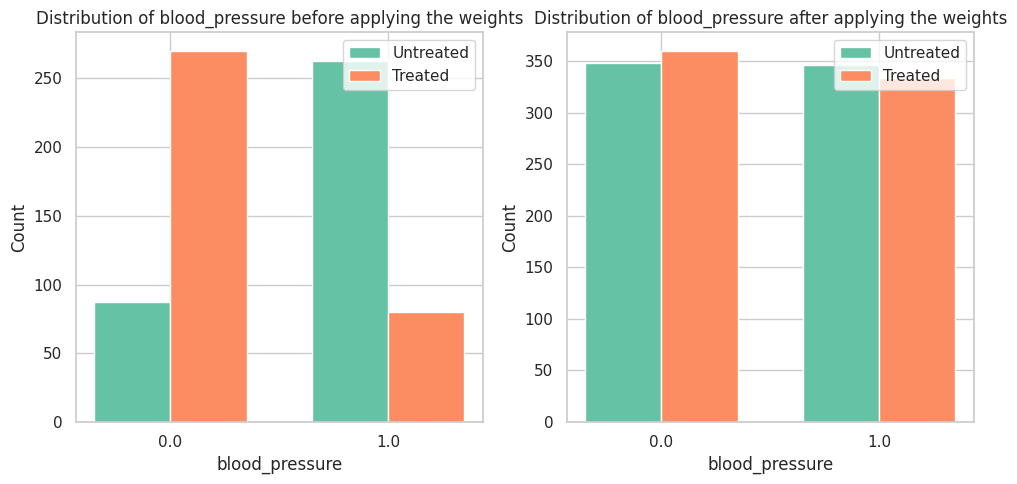

In [42]:
estimate.interpret(method_name="confounder_distribution_interpreter",
                   var_type='discrete', var_name='blood_pressure',
                   fig_size = (10, 5), font_size = 12)

Соответствуют ли полученные выше распределения теоретически ожидаемым?

**Ответ:**

После применения весов распределение значений **blood_pressure** для обеих групп (treated и untreated) выравнивается, что соответствует теоретически ожидаемому результату: веса корректируют различия между группами, что приводит к более сбалансированным распределениям и устраняет искажения, вызванные конфаундерами.

### 2.4. Тестирование полученной оценки

```
model.refute_estimate(
    estimand,
    estimate,
    method_name=None,
    show_progress_bar=False,
    **kwargs,
)
```

Одно из основных преимущество DoWhy &mdash; несколько методов проверки устойчивости моделей.

Поддерживаемые методы опровержения
* **Добавить рандомный конфаундер:** Изменяет ли метод свою оценку добавления конфаундера-рандом в набор данных?
    * *так не должно быть*

* **Тритмент:** Что происходит с предполагаемым причинно-следственным эффектом, если мы тритмент заменим на рандом?
    * *эффект должен быть равен нулю*

* **Фиктивный результат:** Что происходит с предполагаемым причинно-следственным эффектом, при замене таргета на рандом?
    * *эффект должен быть равен нулю*

* **Моделирование:** Что происходит с предполагаемым причинно-следственным эффектом, при замене реального набора данных на искусственный, наиболее похожий по отношению к данному набору данных?
    * *он должен соответствовать параметру effect из процесса генерации данных*

* **Добавить ненаблюдаемый конфаундер:** Насколько чувствительна оценка эффекта при дополнительного конфаундера?
    * *она не должен быть слишком чувствительным*

* **Проверка подмножеств данных:** Существенно ли изменяется оцененный эффект при замене данных на случайно выбранное подмножество?
    * *так не должно быть*

* **Проверка бутстрепом:** Существенно ли меняется предполагаемый эффект при замене данных на бутстрепные рализации?
    * *так не должно быть*


In [43]:
refute_results = model.refute_estimate(
    identified_estimand, estimate,
    method_name="random_common_cause",
    show_progress_bar=True
)

print(refute_results)

Refuting Estimates:   0%|          | 0/100 [00:00<?, ?it/s]

Refute: Add a random common cause
Estimated effect:-0.050352250079951255
New effect:-0.05035225007995127
p value:1.0



In [44]:
refute_results = model.refute_estimate(
    identified_estimand, estimate,
    method_name="add_unobserved_common_cause",
    show_progress_bar=True
)

print(refute_results)

Refute: Add an Unobserved Common Cause
Estimated effect:-0.050352250079951255
New effect:-0.06962060222842636



In [45]:
refute_results = model.refute_estimate(
    identified_estimand, estimate,
    method_name="placebo_treatment_refuter",
    show_progress_bar=True
)

print(refute_results)

Refuting Estimates:   0%|          | 0/100 [00:00<?, ?it/s]

Refute: Use a Placebo Treatment
Estimated effect:-0.050352250079951255
New effect:-0.08172348864109705
p value:0.02



In [46]:
refute_results = model.refute_estimate(
    identified_estimand, estimate,
    method_name="data_subset_refuter",
    show_progress_bar=True
)

print(refute_results)

Refuting Estimates:   0%|          | 0/100 [00:00<?, ?it/s]

Refute: Use a subset of data
Estimated effect:-0.050352250079951255
New effect:-0.04750084079614864
p value:0.8



**Вывод:**

1. **Добавление рандомного конфаундера**:

Оценка эффекта не изменилась (новый эффект: **−0.05035**, p-значение = 1.0), что подтверждает устойчивость результата.

2. **Добавление ненаблюдаемого конфаундера**:

Эффект изменился (новый эффект: **−0.0696**), что может указывать на чувствительность модели к конфаундерам, которые не были учтены.

3. **Использование фиктивного тритмента**:

Эффект значительно изменился (новый эффект: **−0.0817**, p-значение = 0.02), что указывает на возможность того, что модель чувствительна к замене тритмента на случайный.

4. **Проверка подмножеств данных**:

Эффект не изменился существенно (новый эффект: **−0.0475**, p-значение = 0.8), что подтверждает стабильность оценки при случайном подмножестве данных.